In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
from pathlib import Path
image_dir = Path("/content/drive/MyDrive/pics")

In [4]:
test_images = []
for ext in ["*.jpg", "*.png", "*.jpeg", "*.JPG", "*.PNG", "*.JPEG"]:
    test_images.extend(image_dir.glob(ext))

test_images

[PosixPath('/content/drive/MyDrive/pics/IMG_5151.JPG'),
 PosixPath('/content/drive/MyDrive/pics/IMG_5153.JPG'),
 PosixPath('/content/drive/MyDrive/pics/IMG_5154.JPG'),
 PosixPath('/content/drive/MyDrive/pics/IMG_5152.PNG')]

In [31]:
!pip install pytesseract
!pip install jiwer
!apt-get install -y tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [32]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from jiwer import wer, cer

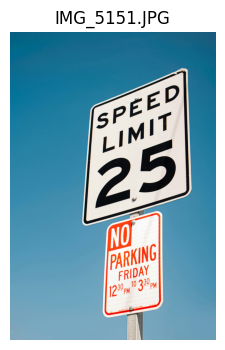

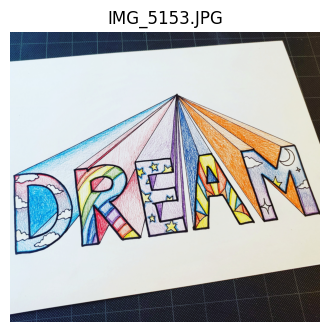

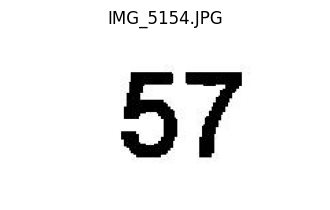

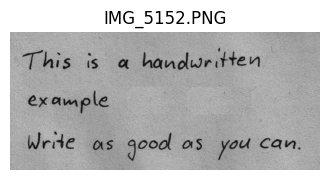

In [33]:
for img_path in test_images:
    img = cv2.imread(str(img_path))
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_path.name)
    plt.axis("off")

In [43]:
ground_truth = {
    "IMG_5151": "SPEED LIMIT 25 NO PARKING FRIDAY 12 30 PM TO 3 30 PM",
    "IMG_5153": "DREAM",
    "IMG_5154": "57",
    "IMG_5152": "This is a handwritten example Write as good as you can",
}

In [36]:
def full_preprocess(img):
    # Resize
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding
    _, thresh = cv2.threshold(
        blurred,
        127,
        255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )


    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded = cv2.erode(thresh, kernel, iterations=1)

    return eroded


In [44]:
pytesseract_results = []

total_cer = 0
total_wer = 0
count = 0

for img_path in test_images:
    key = img_path.stem.upper()

    if key not in ground_truth:
        print("Skipping (no GT):", img_path.name)
        continue

    img = cv2.imread(str(img_path))
    processed = full_preprocess(img)

    pred_text = pytesseract.image_to_string(
        processed,
        config="--oem 3 --psm 6"
    ).strip()

    gt_text = ground_truth[key]

    c = cer(gt_text, pred_text)
    w = wer(gt_text, pred_text)

    total_cer += c
    total_wer += w
    count += 1

    pytesseract_results.append({
        "image": img_path.name,
        "prediction": pred_text,
        "CER": c,
        "WER": w
    })

avg_cer = total_cer / count
avg_wer = total_wer / count

pytesseract_results

[{'image': 'IMG_5151.JPG',
  'prediction': 'ae\nAe\nTs\n77M\ni\n;',
  'CER': 0.9615384615384616,
  'WER': 1.0},
 {'image': 'IMG_5153.JPG',
  'prediction': '; .\n<< \\ j \\. > >\nLoa 8 is Soa\noie : \\ Ny 5 She? -\na aa. Si ar < oo —_\nenter ae ey oe eee re\ny - can oad M vy awa , 2) fet ;\ncane ARE Ta ener\nrd : an vt “ - 7 ~ Sa SY a\nte his Sanaa Qe Con\nfiat ae a 4 < nis ot Nan ne o\nSo po f ean ers So\naan Cat id Cn or. wi RG nS\nSe ‘ Py ONG eueee a” ne ene as\nKe . AS yo Ne aa. = A Se\nGi yy cae nnn Te\noe 7 . y 4 . . we ‘ ~ / a aan a . 7\n¥ L : C4 { 2 Gt ‘ i “Ye 4 a aa : - —> ia . 7\nss au a yA - ate rr 2 Co > Lt . ;\nae ~~, - iA ry 4 ex . a 7 ; real 7 oN . .-. nS - ,\na ae 4 x & & aN rn . a . ; a . 5 oe » ~ a\nae ra 7 if reAGLy ! CS en a. Noa\nf ie iN — wa Ree fe ‘ - oy - . i ; ; N se :\nMo A ‘ ita ay te. w es arate <a ie +\na ; f 4 =. a BA a <) i Nee ne AY. a i\n« ; a is - _ ‘x i 2 a x < 7 , ty , S 7 a . ve a. L e .\n; : : fe a9 S . an esa y \' nce AN Se ne Va A ‘J . ; ae\n. bs 

Image: IMG_5151.JPG
OCR Output:
 

Image: IMG_5153.JPG
OCR Output:
 

Image: IMG_5154.JPG
OCR Output:
of

Image: IMG_5152.PNG
OCR Output:
ai marae GTS RT ara
et Ava

Write as ica RN 4a Can,



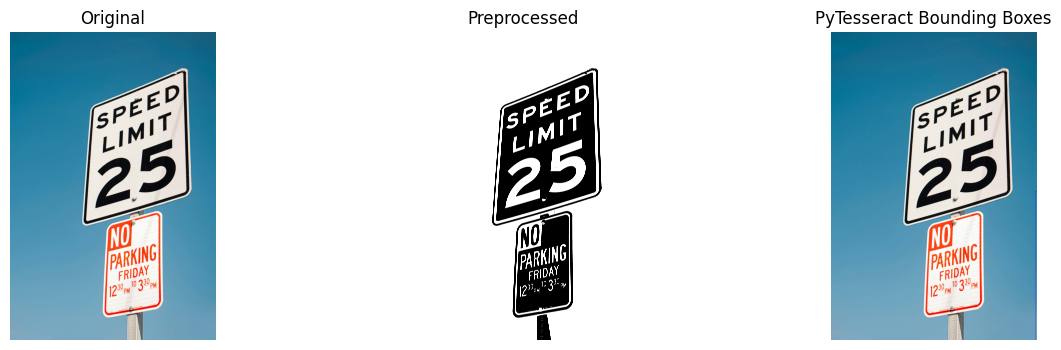

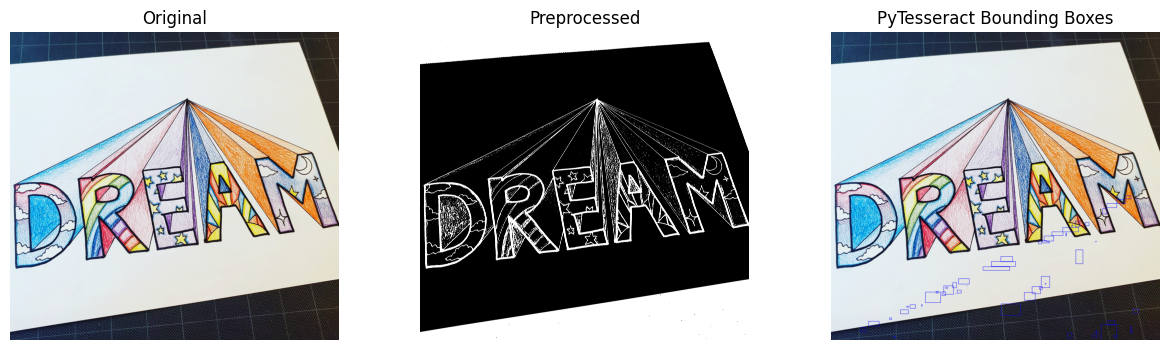

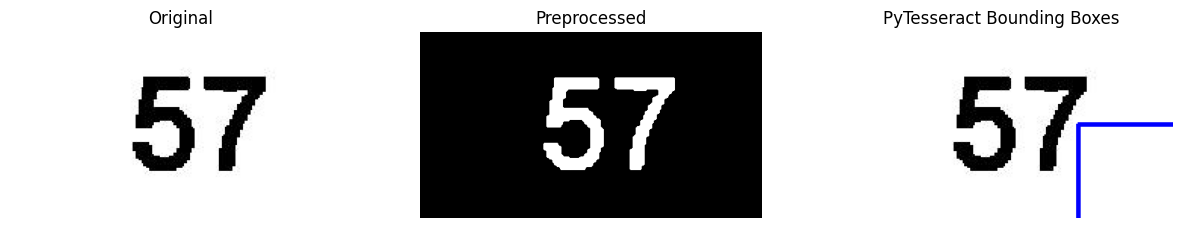

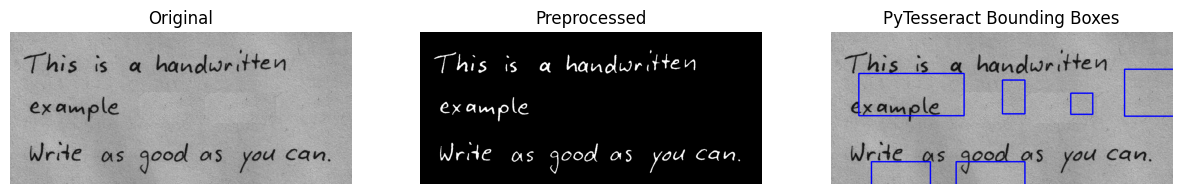

In [45]:
from pytesseract import Output

for img_path in test_images:
    img = cv2.imread(str(img_path))
    proc = full_preprocess(img)

    # ---- Get OCR data with bounding boxes ----
    data = pytesseract.image_to_data(
        proc,
        output_type=Output.DICT,
        config="--oem 3 --psm 6"
    )

    img_box = img.copy()

    for i in range(len(data["text"])):
        word = data["text"][i]
        conf = data["conf"][i]

        # Draw box only for valid detections
        if word.strip() and int(conf) > 0:
            x = data["left"][i]
            y = data["top"][i]
            w = data["width"][i]
            h = data["height"][i]

            cv2.rectangle(
                img_box,
                (x, y),
                (x + w, y + h),
                (255, 0, 0),
                2
            )

    # ---- Visualization ----
    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(proc, cmap="gray")
    plt.title("Preprocessed")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
    plt.title("PyTesseract Bounding Boxes")
    plt.axis("off")

    # ---- OCR text ----
    print("="*60)
    print("Image:", img_path.name)
    print("OCR Output:")
    print(pytesseract.image_to_string(proc))


In [46]:
print("FINAL CER AND WER:-")
print("CER: ",avg_cer)
print("WER: ",avg_wer)

FINAL CER AND WER:-
CER:  91.14223646723646
WER:  155.4090909090909
